# Comparison of the different models

## Loading test data and models

In [20]:
import pandas as pd
from src.models.RandomForestClassifier import RFClassifier
from src.models.KNNClassifier import KNNClassifier
from src.models.SVMClassifier import SVMClassifier
from src.models.NaiveBayesClassifier import NaiveBayesClassifier
from src.models.LogisticRegClassifier import LogisticRegClassifier
from src.models.NNClassifier import NNClassifier
import os
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import time
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook")

In [21]:
# Load data
test_data = pd.read_csv('../data/processed/with_outliers/test.csv')
y_train = pd.read_csv('../data/processed/with_outliers/train.csv') ["class"]
# Split into X and y
y_test = test_data['class']
X_test = test_data.drop('class', axis=1)
# Encode labels
le = LabelEncoder().fit(y_train)
y_test = le.transform(y_test)

In [22]:
RF = RFClassifier()
RF.load(new_name="RandomForest_with_outliers", path="../models/RF/")
LR = LogisticRegClassifier()
LR.load(new_name="LogisticRegression_with_outliers", path="../models/LR/")
NB = NaiveBayesClassifier()
NB.load(new_name="NaiveBayes_with_outliers", path="../models/NB/")
SVM = SVMClassifier()
SVM.load(new_name="SVM_with_outliers", path="../models/SVM/")
KNN = KNNClassifier()
KNN.load(new_name="knn_with_outliers", path="../models/KNN/")
NN = NNClassifier()
NN.load(new_name="nn_with_outliers", path="../models/NN/")

## Comparing the models

### Calculate main metrics (accuracy, f1-score) for each model

In [23]:
models = [RF, LR, NB, SVM, KNN, NN]
reports = pd.DataFrame(columns=['model', 'inference Time (ms)', 'accuracy', 'f1_macro', 'f1_GALAXY', 'f1_QSO', 'f1_STAR'])
for model in models:
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    class_report = classification_report(y_test, y_pred, output_dict=True)
    report = {}
    report['inference Time (ms)'] = (end_time - start_time) * 1000
    report['model'] = model.name
    report['accuracy'] = class_report['accuracy']
    report['f1_macro'] = class_report['macro avg']['f1-score']
    for i in range(len(le.classes_)):
        report[f'f1_{le.inverse_transform([i])[0]}'] = class_report[f'{i}']['f1-score']

    reports = pd.concat([reports, pd.DataFrame([report])], ignore_index=True)

/tmp/ipykernel_352937/1734733584.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reports = pd.concat([reports, pd.DataFrame([report])], ignore_index=True)


### Bar graph of the main metrics

Text(0.5, 1.0, 'Comparison of main metrics for different models')

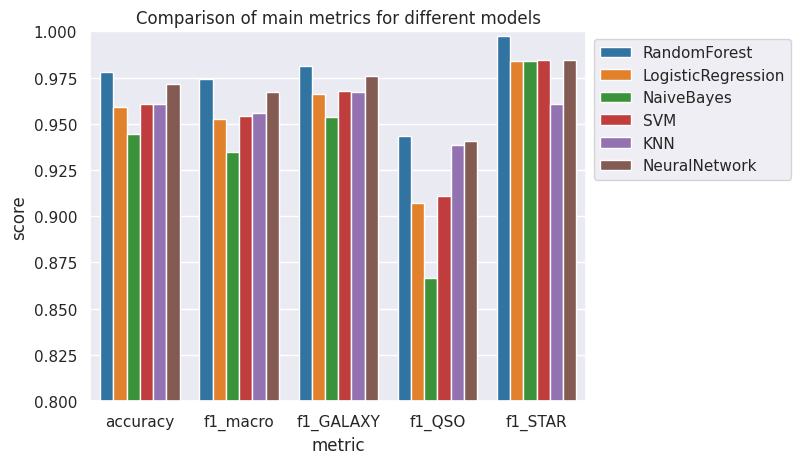

In [24]:
reshaped_reports = reports.melt(id_vars=['model'], value_vars=reports.columns[2:], var_name='metric', value_name='score')

ax = sns.barplot(data=reshaped_reports, x='metric', y='score', hue='model')
ax.set(ylim=(0.8, 1))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Comparison of main metrics for different models')


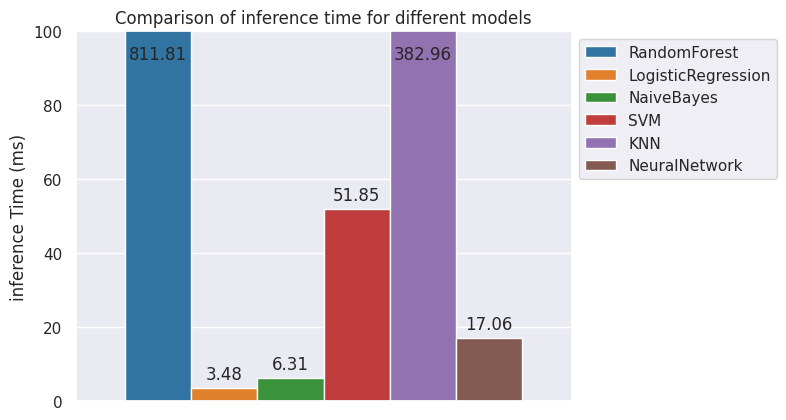

In [48]:
ylim = 100
ax = sns.barplot(data=reports, y='inference Time (ms)', hue='model', )
ax.set_title('Comparison of inference time for different models')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set(ylim=(0, ylim))
for p in ax.patches:
    if p.get_height() == 0:
        continue
    elif p.get_height() > ylim:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., ylim-10),  # Position in the middle of the bar
                    ha='center', va='center', 
                    xytext=(0, 10), textcoords='offset points')
    else:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 10), textcoords='offset points')

### ROC curve for each model

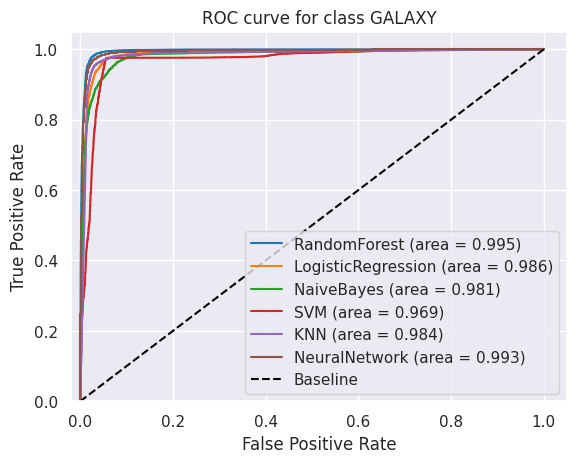

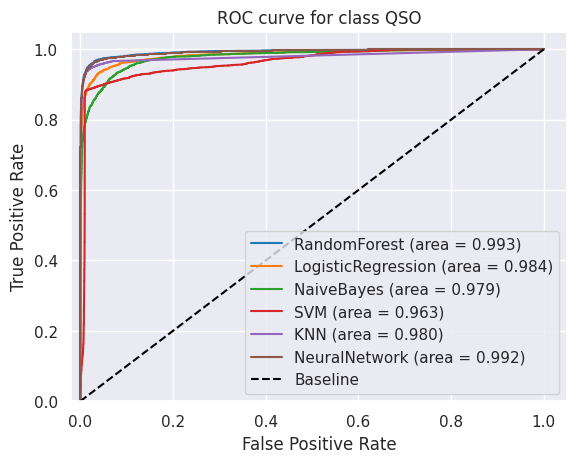

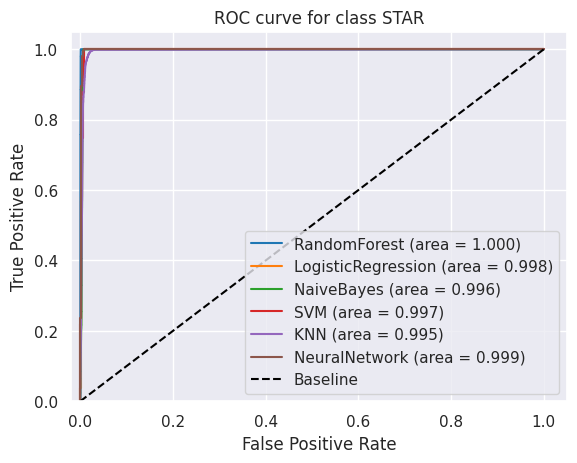

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
n_classes = 3

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

for model in models:
    y_prob = model.model.predict_proba(X_test)
    for i,ax in enumerate([ax1, ax2, ax3]) :
        
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, i], pos_label=i)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{model.name} (area = {roc_auc:0.3f})')
        
for i,ax in enumerate([ax1, ax2, ax3]):
    ax.plot([0, 1], [0, 1], 'k--', label="Baseline")
    ax.set_xlim([-0.02, 1.05])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve for class {}'.format(le.inverse_transform([i])[0]))
    ax.legend(loc="lower right")
    

### Precision-recall curve for each model

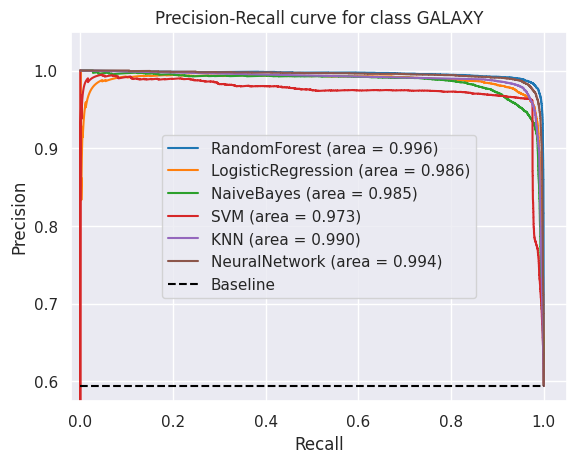

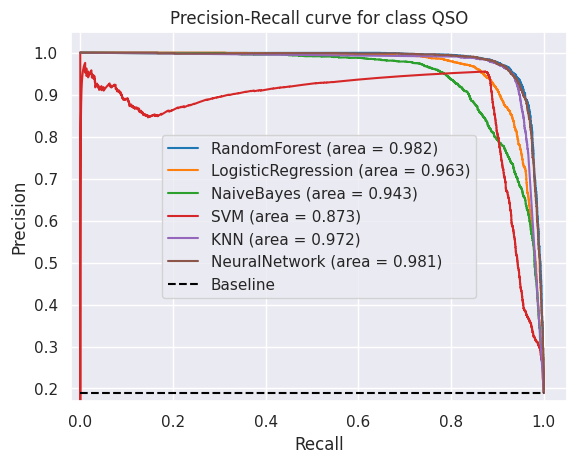

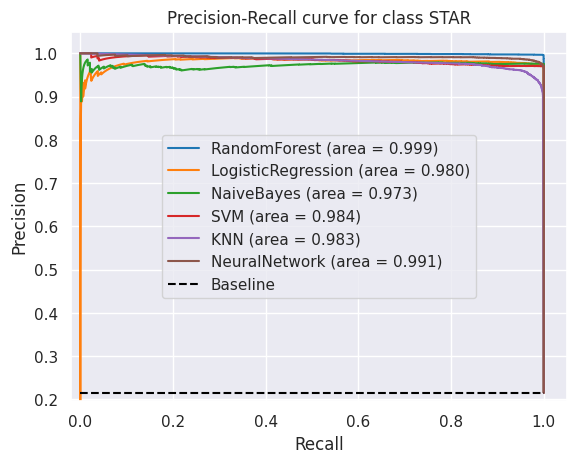

In [27]:
from sklearn.metrics import precision_recall_curve, auc
n_classes = 3

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

for model in models:
    y_prob = model.model.predict_proba(X_test)
    for i, ax in enumerate([ax1, ax2, ax3]):
        
        precision, recall, _ = precision_recall_curve(y_test, y_prob[:, i], pos_label=i)
        
        pr_auc = auc(recall, precision)
        ax.plot(recall, precision, label=f'{model.name} (area = {pr_auc:0.3f})')

for i, ax in enumerate([ax1, ax2, ax3]):
    baseline = len(y_test[y_test == i]) / len(y_test)
    ax.plot([0, 1], [baseline, baseline], 'k--', label='Baseline')
    ax.set_xlim([-0.02, 1.05])
    ax.set_ylim([baseline-0.02, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall curve for class {}'.format(le.inverse_transform([i])[0]))
    ax.legend(loc="best")

plt.show()